In [ ]:
from pandas import read_csv
import pandas as pd
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')

len(data)


10000

In [ ]:
data.value_counts(['Credit_Score'])

,count
Credit_Score,
Standard,5317
Poor,2900
Good,1783


In [ ]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     10000 non-null  object 
 1   Age                       10000 non-null  int64  
 2   Occupation                10000 non-null  object 
 3   Annual_Income             10000 non-null  float64
 4   Monthly_Inhand_Salary     10000 non-null  float64
 5   Num_Bank_Accounts         10000 non-null  int64  
 6   Num_Credit_Card           10000 non-null  int64  
 7   Interest_Rate             10000 non-null  float64
 8   Num_of_Loan               10000 non-null  int64  
 9   Type_of_Loan              10000 non-null  object 
 10  Delay_from_due_date       10000 non-null  float64
 11  Num_of_Delayed_Payment    10000 non-null  int64  
 12  Changed_Credit_Limit      10000 non-null  float64
 13  Num_Credit_Inquiries      10000 non-null  int64  
 14  Credit_

##DECISION TREE WITH BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Undersampling to match 'Poor' class size
undersample = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
print("After Undersampling:", Counter(y_train_resampled))

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_resampled, y_train_resampled)
print("After SMOTE:", Counter(y_train_resampled))

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Train Decision Tree with the best parameters
model = DecisionTreeClassifier(random_state=42, **best_params)
model.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation
y_pred = model.predict(X_test)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Accuracy, Recall, Precision, Specificity
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate Specificity for each class
def calculate_specificity(class_idx):
    # True Negatives for the current class
    tn = cm.sum() - cm[:, class_idx].sum() - cm[class_idx, :].sum() + cm[class_idx, class_idx]
    # False Positives for the current class
    fp = cm[:, class_idx].sum() - cm[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn / (tn + fp)

specificity_poor = calculate_specificity(0)  # Poor class (index 0)
specificity_standard = calculate_specificity(1)  # Standard class (index 1)
specificity_good = calculate_specificity(2)  # Good class (index 2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Specificity for Poor: {specificity_poor:.4f}")
print(f"Specificity for Standard: {specificity_standard:.4f}")
print(f"Specificity for Good: {specificity_good:.4f}")


After Undersampling: Counter({'Poor': 2046, 'Standard': 2046, 'Good': 1231})
After SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.53      0.60      0.56       552
    Standard       0.61      0.70      0.65       854
        Good       0.74      0.65      0.69      1594

    accuracy                           0.65      3000
   macro avg       0.63      0.65      0.64      3000
weighted avg       0.67      0.65      0.66      3000

Confusion Matrix:
[[ 333   43  176]
 [  78  598  178]
 [ 221  341 1032]]
Accuracy: 0.6543
Recall: 0.6543
Precision: 0.6659
Specificity for Poor: 0.8779
Specificity for Standard: 0.8211
Specificity for Good: 0.7482


In [ ]:
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the training set
print("\nTraining Set Distribution:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the test set
print("\nTest Set Distribution:")
print(y_test.value_counts())
print(y_test.value_counts(normalize=True) * 100)


Full Dataset Distribution:
Credit_Score
Standard    5317
Poor        2900
Good        1783
Name: count, dtype: int64
Credit_Score
Standard    53.17
Poor        29.00
Good        17.83
Name: proportion, dtype: float64

Training Set Distribution:
Credit_Score
Standard    3723
Poor        2046
Good        1231
Name: count, dtype: int64
Credit_Score
Standard    53.185714
Poor        29.228571
Good        17.585714
Name: proportion, dtype: float64

Test Set Distribution:
Credit_Score
Standard    1594
Poor         854
Good         552
Name: count, dtype: int64
Credit_Score
Standard    53.133333
Poor        28.466667
Good        18.400000
Name: proportion, dtype: float64


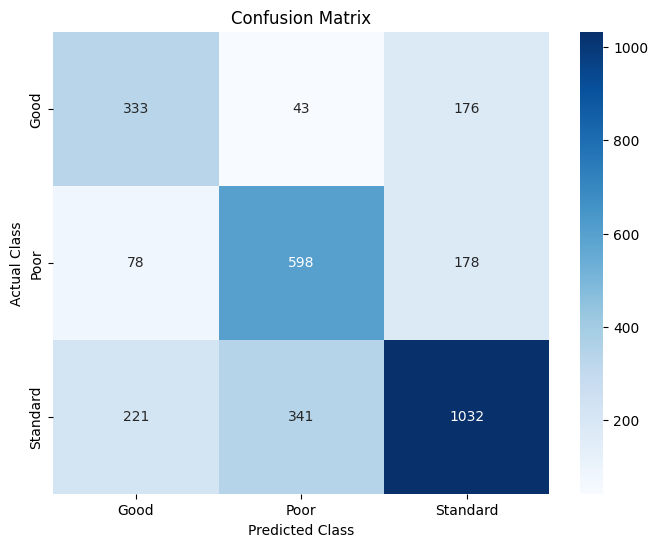

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

##DECISION TREE WITHOUT BALANCING - ALL FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pd

# Load data
data2 = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X2 = data2.drop(columns=['Credit_Score'])
y2 = data2['Credit_Score']

# Encode categorical features
X2_encoded = pd.get_dummies(X2, drop_first=True)

# Split into train and test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_encoded, y2, test_size=0.3, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid2 = {
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini']
}

grid_search2 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid2, cv=5, scoring='accuracy', n_jobs=-1)
grid_search2.fit(X2_train, y2_train)

best_params2 = grid_search2.best_params_
print(f"Best Hyperparameters: {best_params2}")

# Train Decision Tree with the best parameters
model2 = DecisionTreeClassifier(random_state=42, **best_params2)
model2.fit(X2_train, y2_train)

# Predictions and Evaluation
y2_pred = model2.predict(X2_test)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y2_test, y2_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm2 = confusion_matrix(y2_test, y2_pred)
print("Confusion Matrix:")
print(cm2)

# Accuracy, Recall, Precision, Specificity
accuracy2 = accuracy_score(y2_test, y2_pred)
recall2 = recall_score(y2_test, y2_pred, average='weighted')
precision2 = precision_score(y2_test, y2_pred, average='weighted')

# Calculate Specificity for each class
def calculate_specificity2(class_idx):
    # True Negatives for the current class
    tn2 = cm2.sum() - cm2[:, class_idx].sum() - cm2[class_idx, :].sum() + cm2[class_idx, class_idx]
    # False Positives for the current class
    fp2 = cm2[:, class_idx].sum() - cm2[class_idx, class_idx]
    # Specificity = TN / (TN + FP)
    return tn2 / (tn2 + fp2)

specificity2_poor = calculate_specificity2(0)  # Poor class (index 0)
specificity2_standard = calculate_specificity2(1)  # Standard class (index 1)
specificity2_good = calculate_specificity2(2)  # Good class (index 2)

print(f"Accuracy: {accuracy2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"Precision: {precision2:.4f}")
print(f"Specificity for Poor: {specificity2_poor:.4f}")
print(f"Specificity for Standard: {specificity2_standard:.4f}")
print(f"Specificity for Good: {specificity2_good:.4f}")


Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.56      0.55      0.56       552
    Standard       0.68      0.61      0.64       854
        Good       0.71      0.75      0.72      1594

    accuracy                           0.67      3000
   macro avg       0.65      0.64      0.64      3000
weighted avg       0.67      0.67      0.67      3000

Confusion Matrix:
[[ 306   23  223]
 [  61  520  273]
 [ 180  226 1188]]
Accuracy: 0.6713
Recall: 0.6713
Precision: 0.6703
Specificity for Poor: 0.9016
Specificity for Standard: 0.8840
Specificity for Good: 0.6472


In [ ]:
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
print(y2.value_counts())
print(y2.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the training set
print("\nTraining Set Distribution:")
print(y2_train.value_counts())
print(y2_train.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the test set
print("\nTest Set Distribution:")
print(y2_test.value_counts())
print(y2_test.value_counts(normalize=True) * 100)


Full Dataset Distribution:
Credit_Score
Standard    5317
Poor        2900
Good        1783
Name: count, dtype: int64
Credit_Score
Standard    53.17
Poor        29.00
Good        17.83
Name: proportion, dtype: float64

Training Set Distribution:
Credit_Score
Standard    3723
Poor        2046
Good        1231
Name: count, dtype: int64
Credit_Score
Standard    53.185714
Poor        29.228571
Good        17.585714
Name: proportion, dtype: float64

Test Set Distribution:
Credit_Score
Standard    1594
Poor         854
Good         552
Name: count, dtype: int64
Credit_Score
Standard    53.133333
Poor        28.466667
Good        18.400000
Name: proportion, dtype: float64


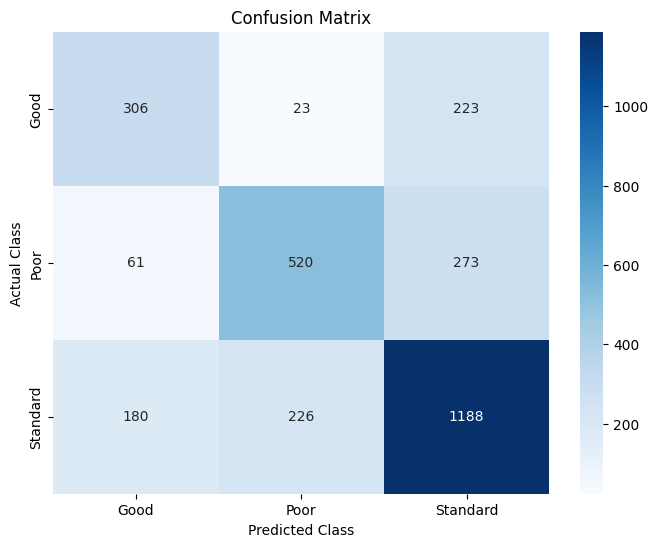

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Poor', 'Standard'], yticklabels=['Good', 'Poor', 'Standard'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

##DECISION TREE WITH BALANCING - SELECTED FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import pandas as pd

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Check dataset distribution before sampling
print("Before Sampling:", Counter(y_train3))

# Undersampling to match 'Poor' class size
undersample = RandomUnderSampler(sampling_strategy={'Standard': 2046}, random_state=42)
X_train3_resampled, y_train3_resampled = undersample.fit_resample(X_train3, y_train3)

# Apply SMOTE to balance 'Good' class to the size of 'Poor'
smote = SMOTE(sampling_strategy={'Good': 2046}, random_state=42)
X_train3_resampled, y_train3_resampled = smote.fit_resample(X_train3_resampled, y_train3_resampled)

# Check dataset distribution after sampling
print("After Undersampling and SMOTE:", Counter(y_train3_resampled))

# Initialize Decision Tree model
base_model = DecisionTreeClassifier(random_state=42)

# Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=base_model, step=5, cv=3, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train3_resampled, y_train3_resampled)

# Get the top 10 selected features
selected_features = X_train3_resampled.columns[rfecv.support_]
top_10_features = selected_features[:10]  # Get only the top 10 features
print(f"Top 10 Features: {top_10_features}")

# Transform datasets to keep only top 10 features
X_train3_rfe = X_train3_resampled[top_10_features]
X_test3_rfe = X_test3[top_10_features]

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini']
}

grid_search3 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search3.fit(X_train3_rfe, y_train3_resampled)

best_params3 = grid_search3.best_params_
print(f"Best Hyperparameters: {best_params3}")

# Train Decision Tree with the best parameters
model3 = DecisionTreeClassifier(random_state=42, **best_params3)
model3.fit(X_train3_rfe, y_train3_resampled)

# Predictions and Evaluation
y3_pred = model3.predict(X_test3_rfe)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test3, y3_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm3 = confusion_matrix(y_test3, y3_pred)
print("Confusion Matrix:")
print(cm3)

# Accuracy, Recall, Precision, Specificity
accuracy3 = accuracy_score(y_test3, y3_pred)
recall3 = recall_score(y_test3, y3_pred, average='weighted')
precision3 = precision_score(y_test3, y3_pred, average='weighted')

def calculate_specificity(class_idx):
    tn = cm3.sum() - cm3[:, class_idx].sum() - cm3[class_idx, :].sum() + cm3[class_idx, class_idx]
    fp = cm3[:, class_idx].sum() - cm3[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor3 = calculate_specificity(0)
specificity_standard3 = calculate_specificity(1)
specificity_good3 = calculate_specificity(2)

print(f"Accuracy: {accuracy3:.4f}")
print(f"Recall: {recall3:.4f}")
print(f"Precision: {precision3:.4f}")
print(f"Specificity for Poor: {specificity_poor3:.4f}")
print(f"Specificity for Standard: {specificity_standard3:.4f}")
print(f"Specificity for Good: {specificity_good3:.4f}")


Before Sampling: Counter({'Standard': 3723, 'Poor': 2046, 'Good': 1231})
After Undersampling and SMOTE: Counter({'Good': 2046, 'Poor': 2046, 'Standard': 2046})
Top 10 Features: Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit'],
      dtype='object')
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.41      0.75      0.53       552
    Standard       0.59      0.67      0.62       854
        Good       0.72      0.46      0.56      1594

    accuracy                           0.57      3000
   macro avg       0.57      0.62      0.57      3000
weighted avg       0.63      0.57      0.57      3000

Confusion Matrix:
[[412  39 101]
 [103 568 183]
 [493 363 738]]
Ac

In [ ]:
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the training set
print("\nTraining Set Distribution:")
print(y_train3.value_counts())
print(y_train3.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the test set
print("\nTest Set Distribution:")
print(y_test3.value_counts())
print(y_test3.value_counts(normalize=True) * 100)



Full Dataset Distribution:
Full Dataset Distribution:
Credit_Score
Standard    5317
Poor        2900
Good        1783
Name: count, dtype: int64
Credit_Score
Standard    53.17
Poor        29.00
Good        17.83
Name: proportion, dtype: float64

Training Set Distribution:
Credit_Score
Standard    3723
Poor        2046
Good        1231
Name: count, dtype: int64
Credit_Score
Standard    53.185714
Poor        29.228571
Good        17.585714
Name: proportion, dtype: float64

Test Set Distribution:
Credit_Score
Standard    1594
Poor         854
Good         552
Name: count, dtype: int64
Credit_Score
Standard    53.133333
Poor        28.466667
Good        18.400000
Name: proportion, dtype: float64


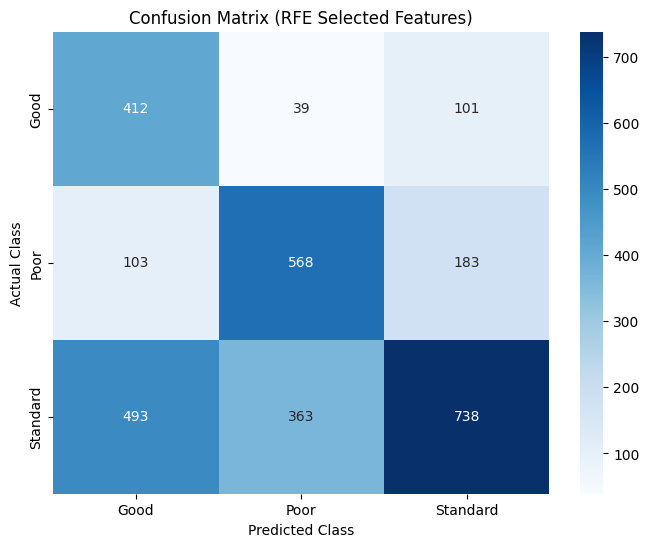

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix for the RFE-selected model
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Poor', 'Standard'],
            yticklabels=['Good', 'Poor', 'Standard'])
plt.title('Confusion Matrix (RFE Selected Features)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()


##DECISION TREE WITHOUT BALANCING - S FEATURES

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix
import pandas as pd

# Load data
data = pd.read_csv('/content/Credit_Score_Cleaned_Data.csv')
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

# Encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split into train and test
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Check dataset distribution before sampling
print("Before Sampling:", Counter(y_train4))

# Initialize Decision Tree model
base_model = DecisionTreeClassifier(random_state=42)

# Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(estimator=base_model, step=5, cv=3, scoring='accuracy', n_jobs=-1)
rfecv.fit(X_train4, y_train4)

# Get the top 10 selected features
selected_features = X_train4.columns[rfecv.support_]
top_10_features = selected_features[:10]  # Get only the top 10 features
print(f"Top 10 Features: {top_10_features}")

# Transform datasets to keep only top 10 features
X_train4_rfe = X_train4[top_10_features]
X_test4_rfe = X_test4[top_10_features]

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini']
}

grid_search4 = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search4.fit(X_train4_rfe, y_train4)

best_params4 = grid_search4.best_params_
print(f"Best Hyperparameters: {best_params4}")

# Train Decision Tree with the best parameters
model4 = DecisionTreeClassifier(random_state=42, **best_params4)
model4.fit(X_train4_rfe, y_train4)

# Predictions and Evaluation
y4_pred = model4.predict(X_test4_rfe)

# Classification Report and Metrics
print("Classification Report:")
print(classification_report(y_test4, y4_pred, target_names=['Poor', 'Standard', 'Good']))

# Confusion Matrix
cm4 = confusion_matrix(y_test4, y4_pred)
print("Confusion Matrix:")
print(cm4)

# Accuracy, Recall, Precision, Specificity
accuracy4 = accuracy_score(y_test4, y4_pred)
recall4 = recall_score(y_test4, y4_pred, average='weighted')
precision4 = precision_score(y_test4, y4_pred, average='weighted')

def calculate_specificity(class_idx):
    tn = cm4.sum() - cm4[:, class_idx].sum() - cm4[class_idx, :].sum() + cm4[class_idx, class_idx]
    fp = cm4[:, class_idx].sum() - cm4[class_idx, class_idx]
    return tn / (tn + fp)

specificity_poor4 = calculate_specificity(0)
specificity_standard4 = calculate_specificity(1)
specificity_good4 = calculate_specificity(2)

print(f"Accuracy: {accuracy4:.4f}")
print(f"Recall: {recall4:.4f}")
print(f"Precision: {precision4:.4f}")
print(f"Specificity for Poor: {specificity_poor4:.4f}")
print(f"Specificity for Standard: {specificity_standard4:.4f}")
print(f"Specificity for Good: {specificity_good4:.4f}")


Before Sampling: Counter({'Standard': 3723, 'Poor': 2046, 'Good': 1231})
Top 10 Features: Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit'],
      dtype='object')
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Classification Report:
              precision    recall  f1-score   support

        Poor       0.53      0.56      0.55       552
    Standard       0.64      0.56      0.60       854
        Good       0.67      0.70      0.69      1594

    accuracy                           0.64      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.64      0.64      0.64      3000

Confusion Matrix:
[[ 310   17  225]
 [  55  479  320]
 [ 217  255 1122]]
Accuracy: 0.6370
Recall: 0.6370
Precision: 0.6372
Specificity for Poor: 0.8889
S

In [ ]:
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
# Check the distribution (count and percentage) in the entire dataset
print("Full Dataset Distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the training set
print("\nTraining Set Distribution:")
print(y_train4.value_counts())
print(y_train4.value_counts(normalize=True) * 100)

# Check the distribution (count and percentage) in the test set
print("\nTest Set Distribution:")
print(y_test4.value_counts())
print(y_test4.value_counts(normalize=True) * 100)


Full Dataset Distribution:
Full Dataset Distribution:
Credit_Score
Standard    5317
Poor        2900
Good        1783
Name: count, dtype: int64
Credit_Score
Standard    53.17
Poor        29.00
Good        17.83
Name: proportion, dtype: float64

Training Set Distribution:
Credit_Score
Standard    3723
Poor        2046
Good        1231
Name: count, dtype: int64
Credit_Score
Standard    53.185714
Poor        29.228571
Good        17.585714
Name: proportion, dtype: float64

Test Set Distribution:
Credit_Score
Standard    1594
Poor         854
Good         552
Name: count, dtype: int64
Credit_Score
Standard    53.133333
Poor        28.466667
Good        18.400000
Name: proportion, dtype: float64


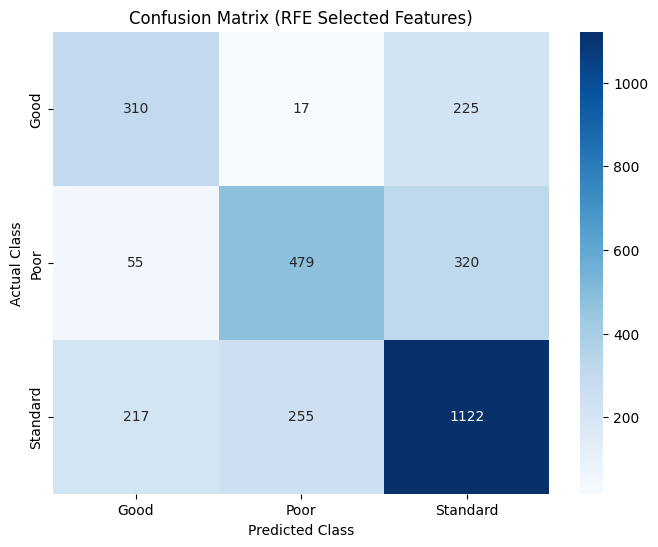

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix for the RFE-selected model
plt.figure(figsize=(8, 6))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good', 'Poor', 'Standard'],
            yticklabels=['Good', 'Poor', 'Standard'])
plt.title('Confusion Matrix (RFE Selected Features)')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

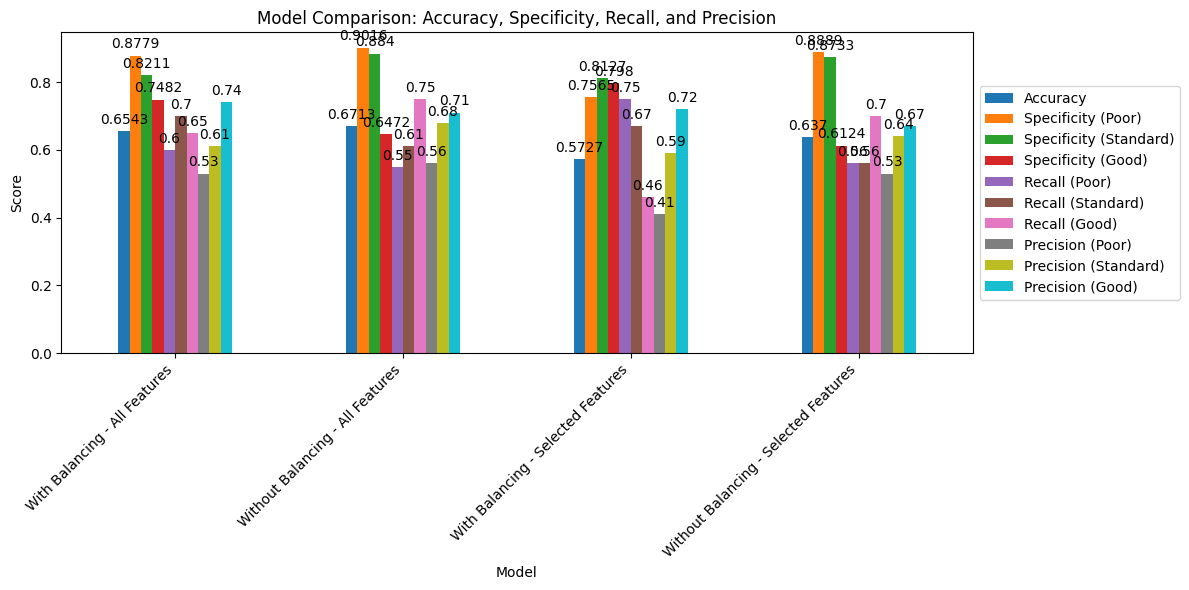

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Comparison Data for Accuracy, Specificity, Recall, and Precision
accuracy_specificity_data = {
    'Model': ['With Balancing - All Features', 'Without Balancing - All Features',
              'With Balancing - Selected Features', 'Without Balancing - Selected Features'],
    'Accuracy': [0.6543, 0.6713, 0.5727, 0.6370],
    'Specificity (Poor)': [0.8779, 0.9016, 0.7565, 0.8889],
    'Specificity (Standard)': [0.8211, 0.8840, 0.8127, 0.8733],
    'Specificity (Good)': [0.7482, 0.6472, 0.7980, 0.6124],
    'Recall (Poor)': [0.60, 0.55, 0.75, 0.56],
    'Recall (Standard)': [0.70, 0.61, 0.67, 0.56],
    'Recall (Good)': [0.65, 0.75, 0.46, 0.70],
    'Precision (Poor)': [0.53, 0.56, 0.41, 0.53],
    'Precision (Standard)': [0.61, 0.68, 0.59, 0.64],
    'Precision (Good)': [0.74, 0.71, 0.72, 0.67]
}

# Create DataFrame for plotting
metrics_df = pd.DataFrame(accuracy_specificity_data)

# Plot the comparison for Accuracy, Specificity, Recall, and Precision
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(12, 6))

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

# Title and labels
plt.title('Model Comparison: Accuracy, Specificity, Recall, and Precision')
plt.ylabel('Score')
plt.xlabel('Model')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()




In [1]:
# Plot the comparison for Accuracy, Specificity, Recall, and Precision with a wider image
ax = metrics_df.set_index('Model').plot(kind='bar', figsize=(20, 15))  # Increase the width

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3)

# Title and labels
plt.title('Model Comparison - DECISION TREES: Accuracy, Specificity, Recall, and Precision')
plt.ylabel('Score')
plt.xlabel('Model')

# Rotate the x-ticks for better readability
plt.xticks(rotation=45, ha='right')

# Move the legend to the right side
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'metrics_df' is not defined